In [1]:
#%% import statements and parameter initialization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
%matplotlib notebook

##Program Parameters
T = 0.5e-3 #Sampleperiod of measurement values = numberOfAveragedValues/Samplerate

#Parameters for sliding average window
oldestBound = 150
youngestBound = 40

#Threshold values during printing
diff_thresh = 0.015
abs_thresh = 1

#Threshold when landing
land_thresh = 0.08

#Folder of experiment result
FOLDER_PATH = None

In [2]:
#%% Gather Data
FILE_Vdefl = FOLDER_PATH + "\\Vdefl.csv"

Data = np.loadtxt(FILE_Vdefl, delimiter=";")

x = Data[:,1]
time = np.linspace(0, len(x)*T, len(x))


##Load log messages
FILE_LOG = FOLDER_PATH + "\\log"
log = pd.read_csv(FILE_LOG, delimiter=": ", names=["time", "message"], engine="python")

def convertToSecond(time):
    clock = np.fromstring(time, dtype=float, sep=":")
    return 3600*clock[0] + 60*clock[1] + clock[2]
log["time"] = log["time"].map(convertToSecond)
log["time"] = log["time"] - log["time"][0]

In [5]:
#This function applies the spike detection criteria and returns the determined values
#Returns:
#diff: the "derivatives" of the signal
#deviations: the difference of the signal to the trailing average
#average_array: the trailing average
def getFeedbackValues(x):
    #Reshape array to "sliding" array, with the five last elements
    arr = [x,
           np.concatenate((np.array([0]), x[:-1])),
           np.concatenate((np.array([0, 0]), x[:-2])),
           np.concatenate((np.array([0, 0, 0]), x[:-3])),
           np.concatenate((np.array([0, 0, 0, 0]), x[:-4]))]
    
    max_arr = np.max(arr, axis=0)
    min_arr = np.min(arr, axis=0)
    
    diff = max_arr-min_arr
    diff[0:5] = np.zeros((5,))
    

    def relu(x):
        if x > 0:
            return x
        else:
            return 0
        
    #Determine the average array
    average_array = np.zeros(len(x))
    for i in range(len(x)):
        if i < oldestBound: #Ignore the setup phase
            pass
        else:
            average_array[i] = np.average(x[relu(i-oldestBound):relu(i-youngestBound)])
        
    deviations = np.abs(x-average_array)
    deviations[:oldestBound] = np.zeros((oldestBound,))
    
    return diff, deviations, average_array
    
    
#This function returns the maximum "derivative" and deviations from the trailing average
def getMaxFeedbackValues(x):
    diff, deviations, temp = getFeedbackValues(x)
    
    max_der = np.max(diff) 
    print("The maximum 'derivative' over 5 elements is ", max_der) 
    
    max_dev = np.max(deviations[oldestBound:]) #Ignore the setup phase
    print("The maximum deviation using the defined average window is ", max_dev)  
    
    
#Plot the signal, the derivative and the absolute criterion
def plotPositiveFeedbacks(x):
    diff, deviations, average_array = getFeedbackValues(x)
    
    fig, a = plt.subplots(3, 1, sharex=True)
    #Plot for Vdefl
    a[0].plot(time, x)
    a[0].set_title("Vdefl")
    
    
    #Plot the derivative/diff method's Feedback
    a[1].plot(time, diff)
    a[1].set_title("Derivative Criterion")
    
    
    #Plot the absolute deviation method's Feedback
    a[2].plot(time, deviations)
    a[2].set_title("Absolute Criterion")
    
    
    #Mark the places where the thresholds have been exceeded
    diff_exceeded = diff > diff_thresh
    #a[0].vlines(time[diff_exceeded], ymin=np.min(x), ymax=np.max(x), colors="g", label="Diff Thresh exceeded")
    a[1].vlines(time[diff_exceeded], ymin=np.min(diff), ymax=np.max(diff), colors="g", label="Diff Thresh exceeded")
    a[1].hlines(diff_thresh, xmin=np.min(time), xmax=np.max(time), colors="g")
    
    dev_exceeded = deviations > abs_thresh
    #a[0].vlines(time[dev_exceeded], ymin=np.min(x), ymax=np.max(x), colors="k", label="Abs Thresh exceeded")
    a[2].vlines(time[dev_exceeded], ymin=np.min(deviations), ymax=np.max(deviations), colors="k", label="Abs Thresh exceeded")    
    a[2].hlines(abs_thresh, xmin=np.min(time), xmax=np.max(time), colors="k")
    

    
    #Landing threshold exceeded
    land_exceeded = deviations > land_thresh
    #a[0].vlines(time[land_exceeded], ymin=np.min(x), ymax=np.max(x), colors="m", label="Landing Thresh exceeded")
    a[2].vlines(time[land_exceeded], ymin=np.min(deviations), ymax=np.max(deviations), colors="m", label="Landing Thresh exceeded")    
    a[2].hlines(land_thresh, xmin=np.min(time), xmax=np.max(time), colors="m")
    
    #Appearance of the plot
    plt.xlabel("time [s]")
    
    a[0].grid(True)
    a[0].legend(loc="upper left")    
    #a[0].set_ylim([np.min(average_array)-0.4, np.max(average_array)+0.4])
    a[1].grid(True)
    a[1].legend(loc="upper left")
    a[1].set_ylim([0,1.1*diff_thresh])
    a[2].grid(True)
    a[2].legend(loc="upper left")
    a[2].set_ylim([0,1.1*abs_thresh])
                  
    #Plot Log 
    for index, row in log.iterrows():
        if "The slope" in row["message"]:
            pass
        elif "Going one layer down" in row["message"]:
            pass
        elif "Searching for pillar" in row["message"]:
            pass
        else:
            if index%2:
                a[0].text(row["time"], x[int(row["time"]/T)]+0.3 , row["message"], fontsize=6)
            else:
                a[0].text(row["time"], x[int(row["time"]/T)]+0.15 , row["message"], fontsize=6)   
        
    plt.show()

<IPython.core.display.Javascript object>


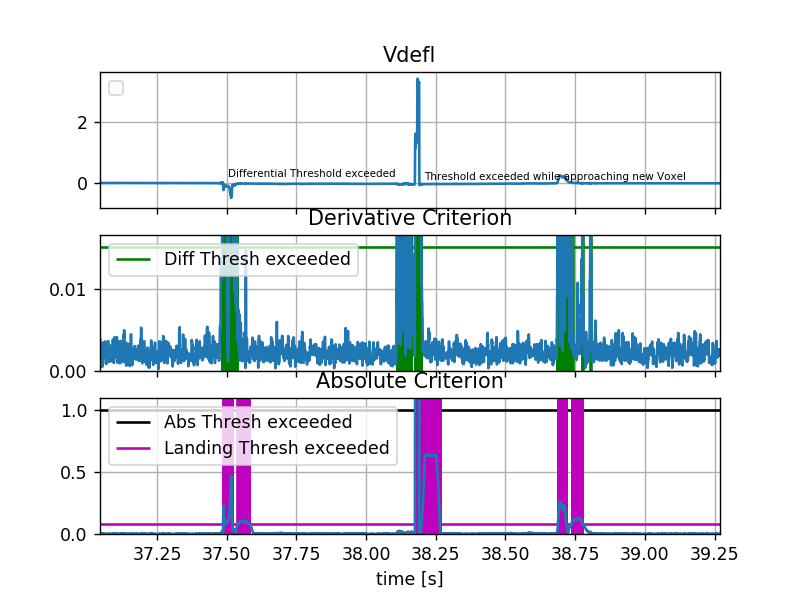

No handles with labels found to put in legend.


In [6]:
#Run the plotting function to create three plots showing all the detection criteria
plotPositiveFeedbacks(x)

<IPython.core.display.Javascript object>


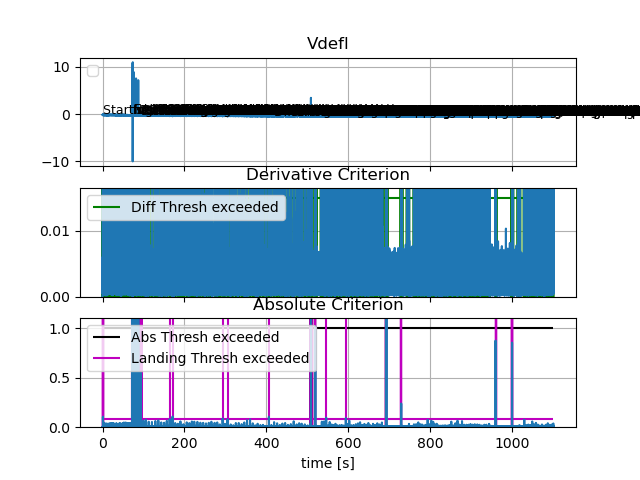

No handles with labels found to put in legend.


In [ ]:
#Only plot the Vdefl signal, in a given range
start = 342480 #Set to None to start with the first value
end = 342520   #Set to None to end with the last value

diff, deviations, average_array = getFeedbackValues(x)
x_plot = x[start:end]
time_plot = time[start:end]
avv_plot = average_array[start:end]

#Plot data
plt.figure("Vdefl Plot")
plt.plot(time_plot, x_plot, color=(0, 89/264, 179/264), label="Vdefl", scalex=False)
plt.legend(fontsize=28)
plt.ylabel("deflection voltage [V]", fontsize=34)
plt.xlabel("time [s]", fontsize=34)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.show()